In [1]:
# 그래프 한글깨짐으로 폰트 설치
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'sudo apt autoremove' to remove it.
The following NEW packages will be installed:
  fonts-nanum
0 upgraded, 1 newly installed, 0 to remove and 20 not upgraded.
Need to get 9,604 kB of archives.
After this operation, 29.5 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 fonts-nanum all 20170925-1 [9,604 kB]
Fetched 9,604 kB in 1s (6,430 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 76, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletyp

In [2]:
# 구글드라이브 마운트
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# 사용할 library import
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# 그래프 한글 및 마이너스 부호 깨짐으로 인한 글씨체 및 마이너스 설정.
plt.rcParams['font.family'] = 'NanumGothic'
plt.rcParams['axes.unicode_minus'] = False
pd.options.display.float_format = '{:.5f}'.format

# **1. 개요**
* **실습 목표**
  * 빌렛 작업지시 데이터, LNG 사용량 데이터를 이용해 가열로의 1일 LNG 사용량을 예측하는 회귀모형을 실습한다.
* **실습 내용**
  * 실습 데이터 불러오기, 탐색적 데이터 분석, 시각화를 통한 데이터 특성 파악
  * 예측에 필요한 파생변수 생성
  * 모델 학습을 위한 DataSet 생성을 위해 데이터 전처리(Data Preprocessing)
  * feature들의 상관관계 확인
  * 데이터 분리(Train, Test)
  * 회귀모형 실습
  * 최종모델 선택 및 튜닝
* **실습 데이터**
  * 가열로는 압연 전 빌렛을 고온 가열을 하기 위한 장치이다.
  * 가열로는 가열대와 균열대로 구분되며 가열대에서는 빌렛을 가열하고, 균열대에서는 두께나 폭방향으로 온도편차가 없도록 소재를 균일하게 가열하는 구간이다.
  * 실습에서 사용하는 데이터는 빌렛 작업지시 데이터와 LNG 사용량 데이터이다.
  * 빌렛 작업지시 데이터는 가열로의 작업지시 및 실적 데이터로 가열로에 투입하는 빌렛의 투입정보(사이즈, 무게), 작업표준정보(표준 균열온도, 표준 작업시간), 작업실적(균열온도, 작업시간, 근무조)로 구성되어 있다.
  * LNG사용량 데이터는 시간단위로 측정한 가열로의 LNG 총사용량을 기록한 데이터로 측정시간, LNG측정량으로 구성되어 있다.
    * LNG측정량은 측정시점의 측정량이 아닌, 측정시간대에 사용된 사용량을 의미한다. 예를들면, 데이터가 아래와 같을경우, 2022-03-29 22:00:00부터 2022-03-29 22:59:59까지 사용한 LNG량이 1420임을 의미한다.


>|컬럼명       | 컬럼값             |
>|-------------|--------------------|
>|measure_date | 2022-03-29 22:00:00|
>|lng_data     | 1420.0             |

  
* **데이터 구성**
  * 데이터는 모두 csv 파일로 빌렛 작업지시 데이터는 약434,000개, LNG 사용량 데이터는 약19,000개의 데이터로 구성되어 있다.

    <빌렛 작업지시 데이터>

      * 목표외경: 압연 완료 후 외경
    
      * 투입외경, 투입길이, 투입중량: 가열로에 투입전 빌렛의 사이즈

      * (표준)균열온도: 균열대에서의 온도

      * (표준)총재로시간: 在爐시간, 가열로 내에서의 체류시간

      * (표준)균열시간: 균열대 체류시간
    
      * (표준)가열시간: 가열대 체류시간

      * 균열온도실적: 실제로 작업한 균열대에서의 온도

  
  
  >| 컬럼명           | 설명                             |
  >|------------------|----------------------------------|
  >|billet_no         |빌렛 구분번호                     |
  >|work_start_date   |작업시작일                        |
  >|work_start_date_time   |작업시작시간                 |
  >|work_end_date_time   |작업종료시간                   |
  >|equip_code        |설비코드                          |
  >|steel_grade_group   |강종그룹                        |
  >|direction_ed      |목표외경                          |
  >|input_ed          |투입외경                          |
  >|input_length      |투입길이                          |
  >|input_wgt         |투입중량                          |
  >|work_shift        |근무조                            |
  >|standard_temperature   |(표준)균열온도               |
  >|total_residence_time   |(표준)총재로시간             |
  >|soaking_zone_time   |(표준)균열시간                  |
  >|heating_zone_time   |(표준)가열시간                  |
  >|heat_temperature    |균열온도실적                    |


  >>><LNG 사용량>


  >| 컬럼명           | 설명                             |
  >|------------------|----------------------------------|
  >|measure_date      |측정일시                          |
  >|lng_data          |LNG측정량                         |



# **2. 데이터 탐색**

### 2-1. 데이터 불러오기
* steel_ai_04_01.csv : LNG 사용량이 기록된 데이터
* steel_ai_04_02.csv : 가열로 빌렛 작업지시 데이터

In [4]:
# pandas library의 read_csv() 함수를 사용하여 csv 파일을 불러와 DataFrame으로 저장한다.
location = '/content/drive/MyDrive/steel_ai_data/'
lng_df = pd.read_csv(location + 'steel_ai_04_01.csv', header=0)
lng_df.head()

,measure_date,lng_data
0,2020-01-01 00:00:00,0.00000
1,2020-01-01 01:00:00,0.00000
2,2020-01-01 02:00:00,0.00000
3,2020-01-01 03:00:00,0.00000
4,2020-01-01 04:00:00,3.00000


In [5]:
heating_df = pd.read_csv(location + 'steel_ai_04_02.csv', header=0)
heating_df.head()

,billet_no,work_start_date,work_start_date_time,work_end_date_time,equip_code,steel_grade_group,direction_ed,input_ed,input_length,input_wgt,work_shift,standard_temperature,total_residence_time,soaking_zone_time,heating_zone_time,heat_temperature
0,C1202001021,2020-01-02 00:00:00.000,2020-01-02 05:00:00,2020-01-02 08:07:00,W,SSK,5.50000,160.00000,8350.00000,1602.00000,C,1200.00000,180.00000,60.00000,120.00000,1065.00000
1,C1202001022,2020-01-02 00:00:00.000,2020-01-02 05:04:00,2020-01-02 08:12:00,W,SSK,5.50000,160.00000,8350.00000,1602.00000,C,1200.00000,180.00000,60.00000,120.00000,1062.00000
2,C1202001023,2020-01-02 00:00:00.000,2020-01-02 05:06:00,2020-01-02 08:16:00,W,SSK,5.50000,160.00000,8350.00000,1602.00000,C,1200.00000,180.00000,60.00000,120.00000,1064.00000
3,C1202001024,2020-01-02 00:00:00.000,2020-01-02 05:17:00,2020-01-02 08:48:00,W,AAB,5.50000,170.00000,8950.00000,2022.00000,C,1080.00000,180.00000,60.00000,120.00000,1116.00000
4,C1202001025,2020-01-02 00:00:00.000,2020-01-02 05:18:00,2020-01-02 08:52:00,W,AAB,5.50000,170.00000,8950.00000,2022.00000,C,1080.00000,180.00000,60.00000,120.00000,1121.00000


### 2-2. 데이터 확인
* LNG 사용량 데이터(lng_df)
  * Null인 데이터는 존재하지 않음.
  * measure_date 컬럼은 날짜 데이터이지만 object형으로 되어있기 때문에, 데이터 타입을 datetime으로 변환해야 함.

* 빌렛 작업지시 데이터(heating_df)
  * equip_code, steel_grade_group, input_ed, input_length, work_shift 컬럼에서 일부 Null 데이터가 있는 것으로 확인됨.
  * work_start_date, work_start_date_time, work_end_date_time 컬럼은 날짜 데이터이지만 object형으로 되어있기 때문에, 데이터 타입을 datetime으로 변환해야 함.

In [ ]:
# .info() 함수를 사용하여 DataFrame을 구성하는 행과 열의 크기, 컬럼명, 컬럼의 데이터 타입, null이 아닌 값의 수를 확인할 수 있다.
lng_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19627 entries, 0 to 19626
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   measure_date  19627 non-null  object 
 1   lng_data      19627 non-null  float64
dtypes: float64(1), object(1)
memory usage: 306.8+ KB


In [ ]:
# .head() 함수를 사용하여 상위 5개의 행을 출력하여 DataFrame 각 컬럼의 데이터형을 확인할 수 있다.
lng_df.head()

,measure_date,lng_data
0,2020-01-01 00:00:00,0.00000
1,2020-01-01 01:00:00,0.00000
2,2020-01-01 02:00:00,0.00000
3,2020-01-01 03:00:00,0.00000
4,2020-01-01 04:00:00,3.00000


In [ ]:
heating_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 434267 entries, 0 to 434266
Data columns (total 16 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   billet_no             434267 non-null  object 
 1   work_start_date       434267 non-null  object 
 2   work_start_date_time  434267 non-null  object 
 3   work_end_date_time    434267 non-null  object 
 4   equip_code            434265 non-null  object 
 5   steel_grade_group     434264 non-null  object 
 6   direction_ed          434267 non-null  float64
 7   input_ed              434264 non-null  float64
 8   input_length          434258 non-null  float64
 9   input_wgt             434267 non-null  float64
 10  work_shift            433602 non-null  object 
 11  standard_temperature  434267 non-null  float64
 12  total_residence_time  434267 non-null  float64
 13  soaking_zone_time     434267 non-null  float64
 14  heating_zone_time     434267 non-null  float64
 15  

In [ ]:
heating_df.head()

,billet_no,work_start_date,work_start_date_time,work_end_date_time,equip_code,steel_grade_group,direction_ed,input_ed,input_length,input_wgt,work_shift,standard_temperature,total_residence_time,soaking_zone_time,heating_zone_time,heat_temperature
0,C1202001021,2020-01-02 00:00:00.000,2020-01-02 05:00:00,2020-01-02 08:07:00,W,SSK,5.50000,160.00000,8350.00000,1602.00000,C,1200.00000,180.00000,60.00000,120.00000,1065.00000
1,C1202001022,2020-01-02 00:00:00.000,2020-01-02 05:04:00,2020-01-02 08:12:00,W,SSK,5.50000,160.00000,8350.00000,1602.00000,C,1200.00000,180.00000,60.00000,120.00000,1062.00000
2,C1202001023,2020-01-02 00:00:00.000,2020-01-02 05:06:00,2020-01-02 08:16:00,W,SSK,5.50000,160.00000,8350.00000,1602.00000,C,1200.00000,180.00000,60.00000,120.00000,1064.00000
3,C1202001024,2020-01-02 00:00:00.000,2020-01-02 05:17:00,2020-01-02 08:48:00,W,AAB,5.50000,170.00000,8950.00000,2022.00000,C,1080.00000,180.00000,60.00000,120.00000,1116.00000
4,C1202001025,2020-01-02 00:00:00.000,2020-01-02 05:18:00,2020-01-02 08:52:00,W,AAB,5.50000,170.00000,8950.00000,2022.00000,C,1080.00000,180.00000,60.00000,120.00000,1121.00000


### 2-3. 분포확인

* LNG 사용량 데이터(lng_df)의 LNG 측정량 컬럼(lng_data)의 분포 확인: box-plot 사용
  * 마이너스 이상치가 존재하여 box-plot으로 분포 확인이 어려움. [4-1]에서 이상치 제거 후 다시 확인

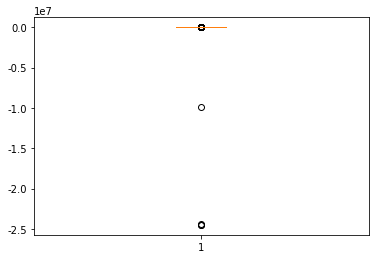

In [ ]:
fig, ax = plt.subplots()
ax.boxplot(lng_df['lng_data'])
plt.show()

In [ ]:
# 마이너스값이 존재하는 것을 확인할 수 있음.
lng_df['lng_data'].describe()

count       19627.00000
mean        -2875.01131
std        310854.88370
min     -24516640.00000
25%          1150.00000
50%          1410.00000
75%          1690.00000
max          3180.00000
Name: lng_data, dtype: float64

* 빌렛 작업지시 데이터(heating_df)의 수치형 컬럼의 분포 확인
  * 총 9개 컬럼: direction_ed, input_ed, input_length, input_wgt, standard_temperature, total_residence_time, soaking_zone_time, heating_zone_time, heat_temperature

In [ ]:
# 수치형 컬럼만 추출
df1 = heating_df.select_dtypes([int, float])

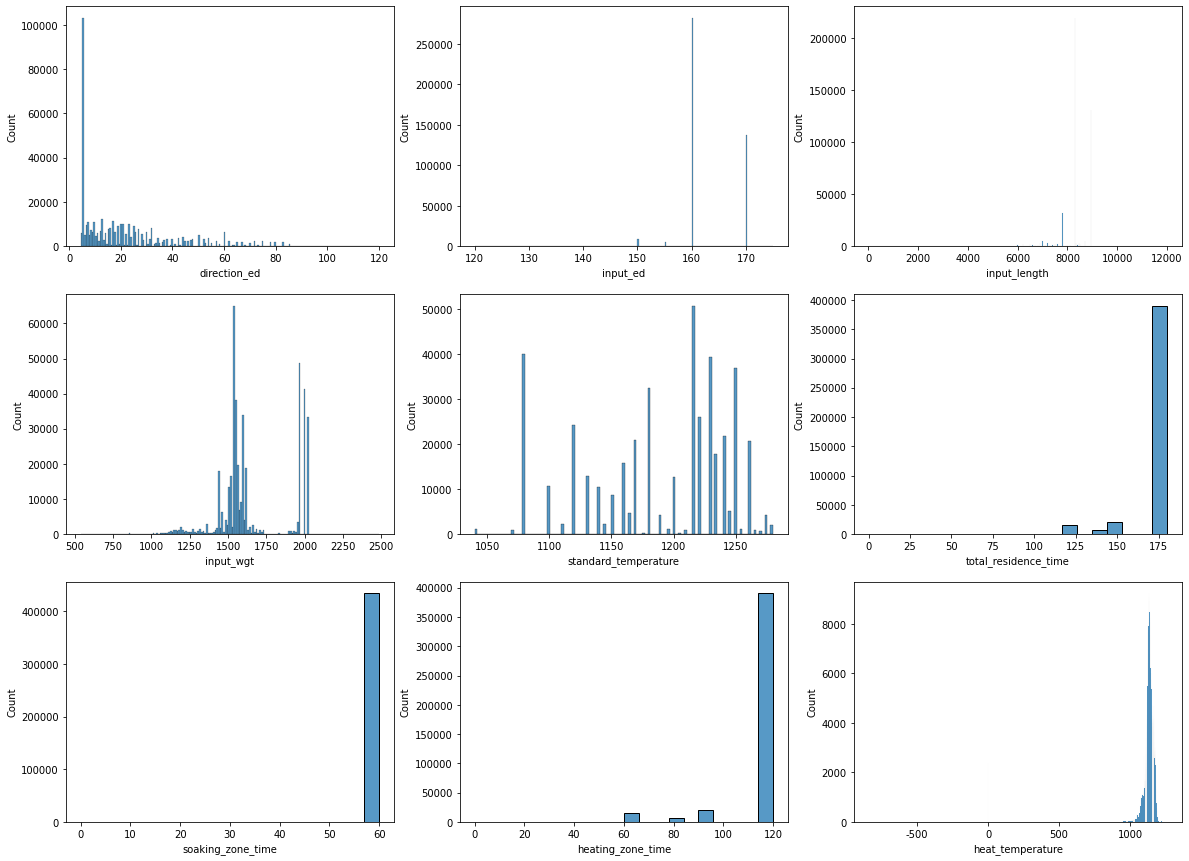

In [ ]:
# 히스토그램 확인
plt.figure(figsize=(20, 15))
for idx, col in enumerate(df1.columns):
  plt.subplot(3, 3, idx+1)
  sns.histplot(data = df1, x = col)

* 빌렛 작업지시 데이터(heating_df)의 표준균열온도, 투입중량의 box-plot 확인

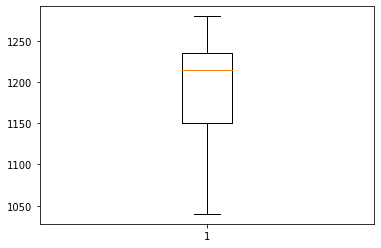

In [ ]:
plt.boxplot(heating_df['standard_temperature'])
plt.show()

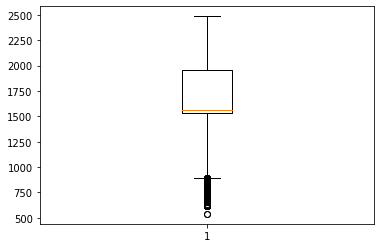

In [ ]:
plt.boxplot(heating_df['input_wgt'])
plt.show()

# **3. 데이터 전처리**

### 3-1. 데이터 타입 변경

In [ ]:
# object 타입이였던 컬럼을 datetime 타입으로 변경
lng_df['measure_date'] = pd.to_datetime(lng_df['measure_date'])

In [ ]:
lng_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19627 entries, 0 to 19626
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   measure_date  19627 non-null  datetime64[ns]
 1   lng_data      19627 non-null  float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 306.8 KB


In [ ]:
# object 타입이였던 컬럼을 datetime 타입으로 변경
heating_df['work_start_date'] = pd.to_datetime(heating_df['work_start_date'])
heating_df['work_start_date_time'] = pd.to_datetime(heating_df['work_start_date_time'])
heating_df['work_end_date_time'] = pd.to_datetime(heating_df['work_end_date_time'])

In [ ]:
heating_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 434267 entries, 0 to 434266
Data columns (total 16 columns):
 #   Column                Non-Null Count   Dtype         
---  ------                --------------   -----         
 0   billet_no             434267 non-null  object        
 1   work_start_date       434267 non-null  datetime64[ns]
 2   work_start_date_time  434267 non-null  datetime64[ns]
 3   work_end_date_time    434267 non-null  datetime64[ns]
 4   equip_code            434265 non-null  object        
 5   steel_grade_group     434264 non-null  object        
 6   direction_ed          434267 non-null  float64       
 7   input_ed              434264 non-null  float64       
 8   input_length          434258 non-null  float64       
 9   input_wgt             434267 non-null  float64       
 10  work_shift            433602 non-null  object        
 11  standard_temperature  434267 non-null  float64       
 12  total_residence_time  434267 non-null  float64       
 13 

### 3-2. 파생변수 생성

* 가열로의 LNG 사용량에 영향을 미치는 요인을 다음과 같이 가정한다.
  * 빌렛의 균열온도
    * (직전에 장입된 빌렛의 온도와 비교했을 때)빌렛의 균열온도가 올라가면 온도를 올리기위해 LNG 사용량이 증가할 것이다. -> 균열온도 상승
    * (직전에 장입된 빌렛의 온도와 비교했을 때)빌렛의 균열온도가 동일하면 온도를 유지하기위해 LNG 사용량이 증가할 것이다. -> 균열온도 유지
    * (직전에 장입된 빌렛의 온도와 비교했을 때)빌렛의 균열온도가 내려가는 경우 LNG 사용량이 없을 것이다. -> 균열온도 하강
  * 총재로시간(=가열로 체류시간)
    * 가열로의 체류시간이 길수록 LNG 사용량이 증가할 것이다.
* 위에서 언급한 빌렛의 균열온도의 상승 or 유지 or 하강 여부와 총재로시간을 모두 반영할 수 있는 면적 변수를 파생변수로 생성하여 분석에 활용한다.
  * (직전에 장입된 빌렛보다)균열온도 상승 빌렛: 가열대 면적+균열대 면적
  * (직전에 장입된 빌렛보다)균열온도 유지 빌렛: 가열대 면적+균열대 면적
  * (직전에 장입된 빌렛보다)균열온도 하강 빌렛: 균열대 면적


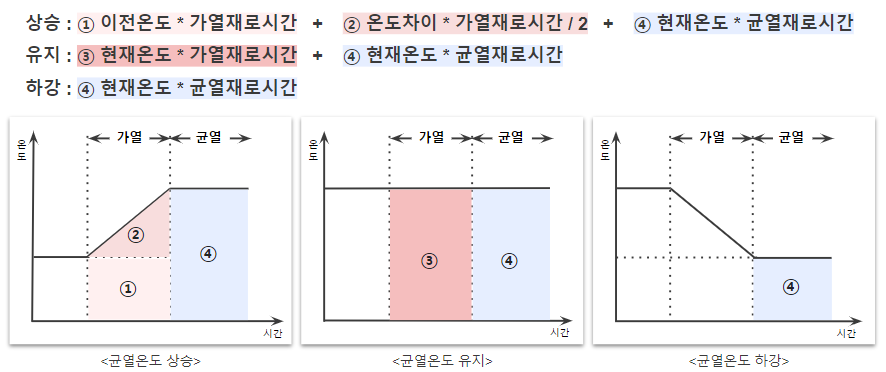



- 직전에 투입한 빌렛의 온도를 나타내는 컬럼 추가

In [ ]:
heating_df = heating_df.sort_values('work_start_date_time') # work_start_date_time을 기준으로 정렬
heating_df['before_temperature'] = heating_df['standard_temperature'].shift(1) # shift 함수를 사용하여 바로위 row의 값을 가져옴

* 빌렛의 가열로(가열대+균열대) 면적 컬럼 추가

In [ ]:
# 상승: 가열+균열구간, 하강: 균열구간, 유지: 가열+균열구간
# bef_temp : 이전온도, std_temp : 현재온도, heating_time : 가열시간, soaking_time : 균열시간, total_time : 총재로시간
def heating_area(bef_temp, std_temp, heating_time, soaking_time, total_time):
  result = 0
  
  if pd.isna(bef_temp) == False:

    # 온도 상승인 case
    if bef_temp < std_temp:
      diff = std_temp - bef_temp # 온도차이값 계산
      area2 = diff * heating_time * 0.5 
      area1 = bef_temp * heating_time
      area4 = std_temp * soaking_time
      result = area2 + area1 + area4

    # 온도 하강인 case
    elif bef_temp > std_temp:
      area4 = std_temp * soaking_time
      result = area4

    # 온도 유지인 case
    else:
      area3 = std_temp * heating_time
      area4 = std_temp * soaking_time
      result = area3 + area4
  
  # 가장 첫번째 row의 경우 이전온도가 없으므로 '유지'로 계산하도록 함.
  else:
    area3 = std_temp * heating_time
    area4 = std_temp * soaking_time
    result = area3 + area4

  return result


In [ ]:
heating_df['area'] = heating_df.apply(lambda x: heating_area(x['before_temperature'], x['standard_temperature'], x['heating_zone_time'], x['soaking_zone_time'], x['total_residence_time']), axis=1)

### 3-3. LNG 사용량 데이터 집계하기

* LNG 사용량을 예측하기 위해서는 현재 수집된 LNG 사용량 데이터의 측정시간(measure_date)동안에 가열로에 장입된 빌렛 리스트를 찾아야 한다.
* [2-3]에서total_residence_time 컬럼의 히스토그램을 통해 빌렛의 총재로시간이 120분 이상임을 확인하였다. 이는 다시말하면 빌렛이 가열로에 장입되고 최소 120분은 지나야 가열로를 나올 수 있다는 의미이다.
* 현재 수집된 LNG 사용량 데이터는 1시간 단위로 측정된 데이터로 측정시간(measure_date)동안에 가열로에 장입된 빌렛 리스트를 찾을경우, 빌렛의 총재로시간(total_residence_time)이 무시되기 때문에 많은 오차가 발생하게 된다.
* 오차를 줄이기 위해서 이번 실습에서는 LNG 사용량과 빌렛 작업지시 데이터를 일단위로 집계하여 분석을 진행한다.

* LNG 사용량 데이터를 일별로 집계하기 위한 기준일자 컬럼 생성

In [ ]:
from dateutil.relativedelta import relativedelta

In [ ]:
lng_df['std_date'] = lng_df.apply(lambda x: pd.to_datetime(x['measure_date'].strftime("%Y-%m-%d")), axis = 1)

* LNG 사용량 데이터 일단위 집계

In [ ]:
lng_df.head(3)

,measure_date,lng_data,std_date
0,2020-01-01 00:00:00,0.00000,2020-01-01
1,2020-01-01 01:00:00,0.00000,2020-01-01
2,2020-01-01 02:00:00,0.00000,2020-01-01


In [ ]:
# groupby 함수를 사용하여 std_date 컬럼을 기준으로 LNG 사용량 데이터를 집계한다.
# 일별 lng_data 컬럼값의 합계를 sum_lng_data라는 컬럼으로 집계하고, 일별 row갯수를 count 컬럼에 집계한다.
grouped_lng_df = lng_df.groupby('std_date', as_index=False).aggregate(sum_lng_data = pd.NamedAgg(column='lng_data', aggfunc='sum'),
                                                                      count = pd.NamedAgg(column='measure_date', aggfunc='size'))

In [ ]:
grouped_lng_df.head()

,std_date,sum_lng_data,count
0,2020-01-01,12630.00000,24
1,2020-01-02,31745.00000,24
2,2020-01-03,31918.00000,24
3,2020-01-04,33109.00000,24
4,2020-01-05,32040.00000,24


### 3-4. 빌렛 작업지시 데이터 집계하기

* 빌렛 작업지시 데이터 일단위 집계

In [ ]:
heating_df.head(3)

,billet_no,work_start_date,work_start_date_time,work_end_date_time,equip_code,steel_grade_group,direction_ed,input_ed,input_length,input_wgt,work_shift,standard_temperature,total_residence_time,soaking_zone_time,heating_zone_time,heat_temperature,before_temperature,area
0,C1202001021,2020-01-02,2020-01-02 05:00:00,2020-01-02 08:07:00,W,SSK,5.50000,160.00000,8350.00000,1602.00000,C,1200.00000,180.00000,60.00000,120.00000,1065.00000,NaN,216000.00000
1,C1202001022,2020-01-02,2020-01-02 05:04:00,2020-01-02 08:12:00,W,SSK,5.50000,160.00000,8350.00000,1602.00000,C,1200.00000,180.00000,60.00000,120.00000,1062.00000,1200.00000,216000.00000
2,C1202001023,2020-01-02,2020-01-02 05:06:00,2020-01-02 08:16:00,W,SSK,5.50000,160.00000,8350.00000,1602.00000,C,1200.00000,180.00000,60.00000,120.00000,1064.00000,1200.00000,216000.00000


In [ ]:
# groupby 함수를 사용하여 work_start_date 컬럼을 기준으로 빌렛 작업지시 데이터를 집계한다.
# 일별 row갯수를 billet_count 컬럼으로 집계하고, 투입중량의 합계를 sum_input_wgt, 면적의 합계를 sum_area에 집계한다.
grouped_heating_df = heating_df.groupby('work_start_date', as_index=False).aggregate(billet_count = pd.NamedAgg(column='billet_no', aggfunc='size'),
                                                                                     sum_input_wgt = pd.NamedAgg(column='input_wgt', aggfunc='sum'),
                                                                                     sum_area = pd.NamedAgg(column='area', aggfunc='sum'))

In [ ]:
grouped_heating_df.head()

,work_start_date,billet_count,sum_input_wgt,sum_area
0,2020-01-02,384,584108.00000,83153400.00000
1,2020-01-03,564,839026.00000,122733000.00000
2,2020-01-04,613,919836.00000,134005500.00000
3,2020-01-05,539,795439.00000,118296900.00000
4,2020-01-06,562,852094.00000,122612100.00000


In [ ]:
grouped_heating_df.describe()

,billet_count,sum_input_wgt,sum_area
count,775.00000,775.00000,775.00000
mean,560.34452,931054.62839,115525713.61290
std,142.24378,270648.63080,27995409.20300
min,5.00000,7925.00000,1062000.00000
25%,477.00000,751597.00000,100263675.00000
50%,550.00000,895457.00000,114999000.00000
75%,662.50000,1160107.00000,132173062.50000
max,929.00000,1713042.00000,188235000.00000


### 3-5. 데이터 합치기
* 일단위로 집계한 LNG 사용량 데이터와 빌렛 작업지시 데이터를 날짜 기준으로 합치기

In [ ]:
grouped_lng_df.head(3)

,std_date,sum_lng_data,count
0,2020-01-01,12630.00000,24
1,2020-01-02,31745.00000,24
2,2020-01-03,31918.00000,24


In [ ]:
grouped_heating_df.head(3)

,work_start_date,billet_count,sum_input_wgt,sum_area
0,2020-01-02,384,584108.00000,83153400.00000
1,2020-01-03,564,839026.00000,122733000.00000
2,2020-01-04,613,919836.00000,134005500.00000


In [ ]:
# pandas library의 merge()함수를 사용하여 두 개의 데이터셋을 합친다. 
join_df = pd.merge(grouped_lng_df, grouped_heating_df, left_on='std_date', right_on='work_start_date', how='inner')

In [ ]:
join_df.head()

,std_date,sum_lng_data,count,work_start_date,billet_count,sum_input_wgt,sum_area
0,2020-01-02,31745.00000,24,2020-01-02,384,584108.00000,83153400.00000
1,2020-01-03,31918.00000,24,2020-01-03,564,839026.00000,122733000.00000
2,2020-01-04,33109.00000,24,2020-01-04,613,919836.00000,134005500.00000
3,2020-01-05,32040.00000,24,2020-01-05,539,795439.00000,118296900.00000
4,2020-01-06,32978.00000,24,2020-01-06,562,852094.00000,122612100.00000


In [ ]:
join_df.describe()

,sum_lng_data,count,billet_count,sum_input_wgt,sum_area
count,775.00000,775.00000,775.00000,775.00000,775.00000
mean,-60243.92258,23.98323,560.34452,931054.62839,115525713.61290
std,1523289.69774,0.16386,142.24378,270648.63080,27995409.20300
min,-24505540.00000,21.00000,5.00000,7925.00000,1062000.00000
25%,30935.00000,24.00000,477.00000,751597.00000,100263675.00000
50%,34370.00000,24.00000,550.00000,895457.00000,114999000.00000
75%,39625.00000,24.00000,662.50000,1160107.00000,132173062.50000
max,51950.00000,24.00000,929.00000,1713042.00000,188235000.00000


# **4. 데이터 탐색**

### 4-1. 분포확인 및 이상치 제거

In [ ]:
join_df.describe()

,sum_lng_data,count,billet_count,sum_input_wgt,sum_area
count,775.00000,775.00000,775.00000,775.00000,775.00000
mean,-60243.92258,23.98323,560.34452,931054.62839,115525713.61290
std,1523289.69774,0.16386,142.24378,270648.63080,27995409.20300
min,-24505540.00000,21.00000,5.00000,7925.00000,1062000.00000
25%,30935.00000,24.00000,477.00000,751597.00000,100263675.00000
50%,34370.00000,24.00000,550.00000,895457.00000,114999000.00000
75%,39625.00000,24.00000,662.50000,1160107.00000,132173062.50000
max,51950.00000,24.00000,929.00000,1713042.00000,188235000.00000


- 하루(24시간)동안의 LNG 사용량이 모두 기록되지 않은 날짜는 제외한다.

In [ ]:
join_df[join_df['count'] < 24]

,std_date,sum_lng_data,count,work_start_date,billet_count,sum_input_wgt,sum_area
216,2020-09-03,18720.00000,22,2020-09-03,110,166219.00000,23165400.00000
235,2020-09-22,33310.00000,23,2020-09-22,592,1040197.00000,121850925.00000
244,2020-10-03,31040.00000,23,2020-10-03,362,647244.00000,71393925.00000
328,2020-12-26,38100.00000,21,2020-12-26,567,1115250.00000,106771300.00000
379,2021-02-16,31890.00000,23,2021-02-16,481,737376.00000,99684000.00000
547,2021-08-11,10660.00000,23,2021-08-11,509,783594.00000,111231900.00000
554,2021-08-18,27870.00000,23,2021-08-18,467,719680.00000,98665750.00000
706,2022-01-19,35830.00000,23,2022-01-19,522,857528.00000,108602400.00000
720,2022-02-04,19650.00000,23,2022-02-04,151,236152.00000,32476200.00000
767,2022-03-23,38070.00000,23,2022-03-23,757,1293952.00000,157351725.00000


In [ ]:
drop_idx1 = join_df[join_df['count'] < 24].index
# count가 24 미만인 데이터의 index를 사용하여 row 삭제
join_df.drop(drop_idx1, inplace=True)

- LNG 사용량이 0이하인 날짜 제외

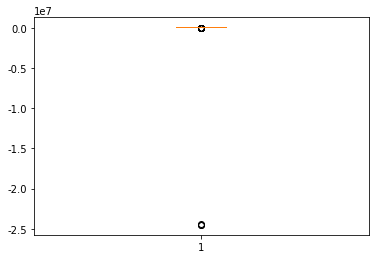

In [ ]:
plt.boxplot(join_df['sum_lng_data'])
plt.show()

In [ ]:
join_df['sum_lng_data'].describe()

count         765.00000
mean       -61404.15686
std       1533192.06542
min     -24505540.00000
25%         30940.00000
50%         34410.00000
75%         39650.00000
max         51950.00000
Name: sum_lng_data, dtype: float64

In [ ]:
join_df[join_df['sum_lng_data'] <= 0]

,std_date,sum_lng_data,count,work_start_date,billet_count,sum_input_wgt,sum_area
413,2021-03-22,-24442540.00000,24,2021-03-22,579,995801.00000,117692925.00000
414,2021-03-23,-24505540.00000,24,2021-03-23,507,909871.00000,100067125.00000
415,2021-03-24,-24492480.00000,24,2021-03-24,711,1206546.00000,145903500.00000
546,2021-08-10,0.00000,24,2021-08-10,350,527277.00000,73944000.00000
576,2021-09-09,0.00000,24,2021-09-09,217,325293.00000,46235700.00000
577,2021-09-10,0.00000,24,2021-09-10,514,751083.00000,112423400.00000
578,2021-09-11,0.00000,24,2021-09-11,534,816786.00000,117630000.00000
579,2021-09-12,0.00000,24,2021-09-12,511,805584.00000,113364600.00000
580,2021-09-13,0.00000,24,2021-09-13,362,559875.00000,77677350.00000
581,2021-09-14,0.00000,24,2021-09-14,416,628192.00000,87660350.00000


In [ ]:
drop_idx2 = join_df[join_df['sum_lng_data'] <= 0].index
join_df.drop(drop_idx2, inplace=True)

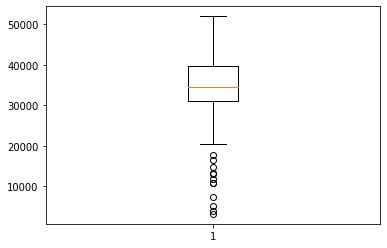

In [ ]:
plt.boxplot(join_df['sum_lng_data'])
plt.show()

In [ ]:
join_df

,std_date,sum_lng_data,count,work_start_date,billet_count,sum_input_wgt,sum_area
0,2020-01-02,31745.00000,24,2020-01-02,384,584108.00000,83153400.00000
1,2020-01-03,31918.00000,24,2020-01-03,564,839026.00000,122733000.00000
2,2020-01-04,33109.00000,24,2020-01-04,613,919836.00000,134005500.00000
3,2020-01-05,32040.00000,24,2020-01-05,539,795439.00000,118296900.00000
4,2020-01-06,32978.00000,24,2020-01-06,562,852094.00000,122612100.00000
...,...,...,...,...,...,...,...
770,2022-03-26,41300.00000,24,2022-03-26,673,1113188.00000,135049125.00000
771,2022-03-27,42980.00000,24,2022-03-27,740,1166384.00000,156190425.00000
772,2022-03-28,44460.00000,24,2022-03-28,795,1229352.00000,170125125.00000
773,2022-03-29,41710.00000,24,2022-03-29,733,1130580.00000,154075650.00000


In [ ]:
# 전체 row수와 실제 index에 차이가 발생함. 따라서 reset_index()를 사용하여 인덱스를 재설정해준다.
join_df.reset_index(inplace=True, drop=True)

### 4-2. 상관관계

In [ ]:
join_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 753 entries, 0 to 752
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   std_date         753 non-null    datetime64[ns]
 1   sum_lng_data     753 non-null    float64       
 2   count            753 non-null    int64         
 3   work_start_date  753 non-null    datetime64[ns]
 4   billet_count     753 non-null    int64         
 5   sum_input_wgt    753 non-null    float64       
 6   sum_area         753 non-null    float64       
dtypes: datetime64[ns](2), float64(3), int64(2)
memory usage: 41.3 KB


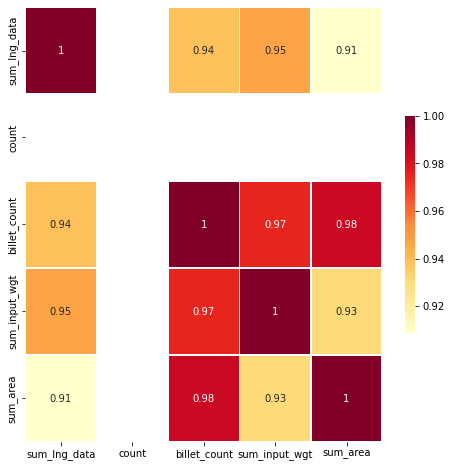

In [ ]:
corr = join_df.corr()
plt.figure(figsize=(8,8))
sns.heatmap(corr, annot=True, cmap = 'YlOrRd', linewidths=.5, cbar_kws={"shrink": .5})

In [ ]:
corr['sum_lng_data'].sort_values(ascending=False)

sum_lng_data    1.00000
sum_input_wgt   0.94719
billet_count    0.93868
sum_area        0.90865
count               NaN
Name: sum_lng_data, dtype: float64

# **5. 모델링**

### 5-1. 준비

In [ ]:
join_df.describe()

,sum_lng_data,count,billet_count,sum_input_wgt,sum_area
count,753.00000,753.00000,753.00000,753.00000,753.00000
mean,35147.91501,24.00000,563.16600,936141.14077,116068205.34529
std,6448.01031,0.00000,140.86935,268675.86160,27684713.47528
min,3230.00000,24.00000,5.00000,7925.00000,1062000.00000
25%,31130.00000,24.00000,478.00000,753289.00000,100908850.00000
50%,34590.00000,24.00000,552.00000,900651.00000,115268950.00000
75%,39730.00000,24.00000,665.00000,1162130.00000,132368175.00000
max,51950.00000,24.00000,929.00000,1713042.00000,188235000.00000


* 미사용 컬럼 제거
  * count 컬럼값이 모두 24로 LNG사용량에 영향을 미치지 않으므로 삭제

In [ ]:
join_df.drop(['count'], inplace=True, axis = 1)

In [ ]:
join_df.head()

,std_date,sum_lng_data,work_start_date,billet_count,sum_input_wgt,sum_area
0,2020-01-02,31745.00000,2020-01-02,384,584108.00000,83153400.00000
1,2020-01-03,31918.00000,2020-01-03,564,839026.00000,122733000.00000
2,2020-01-04,33109.00000,2020-01-04,613,919836.00000,134005500.00000
3,2020-01-05,32040.00000,2020-01-05,539,795439.00000,118296900.00000
4,2020-01-06,32978.00000,2020-01-06,562,852094.00000,122612100.00000


### 5-2. 훈련 데이터, 테스트 데이터 분리
* scikit-learn library의 train_test_split 사용하여 훈련 데이터와 테스트 데이터를 분리한다.

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
# 종속변수: sum_lng_data, 설명변수: sum_input_wgt, sum_area
# 훈련데이터와 학습데이터 비율은 7:3으로 하고, 실행시마다 동일한 결과를 얻기위해 random_state 설정
train_x, test_x, train_y, test_y = train_test_split(join_df[['sum_input_wgt', 'sum_area']], join_df['sum_lng_data'], test_size=0.3, random_state=111)

### 5-3. 다중선형회귀(Multiple Linear Regression)

* 회귀모델 생성

In [ ]:
from sklearn.linear_model import LinearRegression
lr_model = LinearRegression()
lr_model.fit(train_x, train_y)

LinearRegression()

* 결정계수 확인

In [ ]:
print(lr_model.score(train_x, train_y))
print(lr_model.score(test_x, test_y))

0.9295053163052638
0.8545285163651908


* 예측값과 실제값 비교 시각화

In [ ]:
lr_pred_y = lr_model.predict(test_x)

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 49892 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 51228 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 49324 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 50857 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 47049 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 50696 missing from current font.
  font.set_

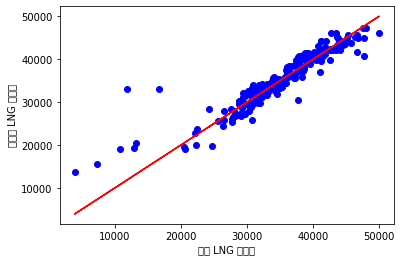

In [ ]:
# 빨간선에 모여있을수록 잘 예측 했다고 말할 수 있음.
plt.scatter(test_y, lr_pred_y, color = 'blue')
plt.plot(test_y, test_y, color='red')
plt.xlabel('실제 LNG 사용량')
plt.ylabel('예측한 LNG 사용량')
plt.show()

### 5-4. 랜덤포레스트(RandomForest)

* 랜덤포레스트 모델 생성

In [ ]:
from sklearn.ensemble import RandomForestRegressor

In [ ]:
rf_model = RandomForestRegressor()
rf_model.fit(train_x, train_y)

RandomForestRegressor()

* 결정계수 확인

In [ ]:
print(rf_model.score(train_x, train_y))
print(rf_model.score(test_x, test_y))

0.9897752491061818
0.8779967255928358


* 예측값과 실제값 비교 시각화

In [ ]:
rf_pred_y = rf_model.predict(test_x)

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 49892 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 51228 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 49324 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 50857 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 47049 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 50696 missing from current font.
  font.set_

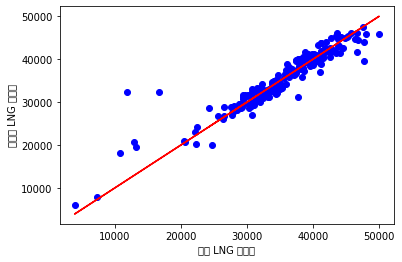

In [ ]:
# 빨간선에 모여있을수록 잘 예측 했다고 말할 수 있음.
plt.scatter(test_y, rf_pred_y, color = 'blue')
plt.plot(test_y, test_y, color='red')
plt.xlabel('실제 LNG 사용량')
plt.ylabel('예측한 LNG 사용량')
plt.show()

### 5-5. 모델 성능 평가
* 회귀모델의 성능평가 지표로 MSE, RMSE, MAE, R-Squared 4가지를 주로 사용한다.
* Mean Squared Error(MSE): 실제값에서 예측값을 뺀 값의 제곱의 평균. 이상치에 민감하다. 제곱한 값이기 대문에 예측값과 단위가 다르다.
* Root Mean Squared Error(RMSE): MSE에 루트를 씌운 값. 
* Mean Absolute Error(MAE): 실제값에서 예측값을 뺀 값의 절대값의 평균. 평균적인 오차가 어느정도 인지 직관적 설명 가능.
* R-Squared(결정계수): 예측값의 분산을 실제값의 분산으로 나눈 값. 1에 가까울수록 성능이 좋은 모델. 추정된 모형이 주어진 데이터에 잘 적합되었는지 판단하는 척도로 주로 사용.

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
# 회귀모델 성능평가 지표로 사용할 4가지(MSE, RMSE, MAE, R-Squared)를 한번에 출력해주는 사용자정의함수 생성
def evaluate_regression(y, pred):
    mse_val = mean_squared_error(y, pred)
    rmse_val = np.sqrt(mean_squared_error(y, pred))
    mae_val = mean_absolute_error(y, pred)
    r2_score_val = r2_score(y, pred)
    print('MSE: {0: .3F}, RMSE: {1: .3F}, MAE: {2: .3F}, r2_score: {3: .3f}'.format(mse_val, rmse_val, mae_val, r2_score_val))

* 다중선형회귀 모델 성능 평가

In [ ]:
evaluate_regression(test_y, lr_pred_y)

MSE:  7397870.315, RMSE:  2719.903, MAE:  1579.218, r2_score:  0.855


* Random Forest 모델 성능 평가

In [ ]:
evaluate_regression(test_y, rf_pred_y)

MSE:  6204407.761, RMSE:  2490.865, MAE:  1421.735, r2_score:  0.878


* 정리
  * 다중선형회귀와 랜덤포레스트의 결과를 비교하였을 때, 결정계수가 각각 0.855, 0.876으로 랜덤포레스트 모델의 적합도가 조금 더 좋은 것을 확인할 수 있다.
  * 두 모델의 MAE를 확인해보면 각각 1,579.218, 1,427.861으로 평균오차가 1,000이상이긴 하나, 1일 LNG 사용량의 평균이 약 35,000인 것을 감안하면 큰 오차라고 할 수 없다.
  * 따라서 두 모형 중 결정계수가 높고, MAE값이 낮은 랜덤포레스트 모델을 최종 모형으로 판단할 수 있다.

# **6. 모델튜닝(랜덤포레스트)**
* 앞에서 최종모형으로 선택한 랜덤포레스트 모델의 적합도를 높이기 위해 모델 튜닝을 수행해본다.

### 6-1. 하이퍼파라미터 튜닝
* max_depth: 트리의 깊이
  * default=None
  * root node와 leaf node 사이의 가장 긴 경로 설정
  * 너무 큰 값을 설정할 경우 모델이 복잡해지고, overfitting 위험이 존재함
* n_estimators: 결정 트리의 개수
  * default=100
  * 트리의 갯수가 많을수록 성능은 좋아지나 무조건 향상되지 않으며, 많을수록 학습 시간이 증가함
  * 트리의 갯수가 너무 작을경우 과소적합 위험이 존재함
* max_feautres: 피처의 개수
  * default=1.0
  * 작을수록 트리가 깊어짐

* max_depth 튜닝

In [ ]:
rf_model_md1 = RandomForestRegressor(max_depth = 1)
rf_model_md5 = RandomForestRegressor(max_depth = 5)
rf_model_md10 = RandomForestRegressor(max_depth = 10)
rf_model_md20 = RandomForestRegressor(max_depth = 20)

rf_model_md1.fit(train_x, train_y)
rf_model_md5.fit(train_x, train_y)
rf_model_md10.fit(train_x, train_y)
rf_model_md20.fit(train_x, train_y)

rf_pred_y_md1 = rf_model_md1.predict(test_x)
rf_pred_y_md5 = rf_model_md5.predict(test_x)
rf_pred_y_md10 = rf_model_md10.predict(test_x)
rf_pred_y_md20 = rf_model_md20.predict(test_x)

print("max_depth=1의 성능")
evaluate_regression(test_y, rf_pred_y_md1)
print("max_depth=5의 성능")
evaluate_regression(test_y, rf_pred_y_md5)
print("max_depth=10의 성능")
evaluate_regression(test_y, rf_pred_y_md10)
print("max_depth=20의 성능")
evaluate_regression(test_y, rf_pred_y_md20)

max_depth=1의 성능
MSE:  22108783.755, RMSE:  4701.998, MAE:  2890.724, r2_score:  0.565
max_depth=5의 성능
MSE:  6062343.304, RMSE:  2462.183, MAE:  1372.344, r2_score:  0.881
max_depth=10의 성능
MSE:  6114630.061, RMSE:  2472.778, MAE:  1392.887, r2_score:  0.880
max_depth=20의 성능
MSE:  6202987.284, RMSE:  2490.580, MAE:  1407.948, r2_score:  0.878


* n_estimators 튜닝

In [ ]:
rf_model_ne1 = RandomForestRegressor(n_estimators = 1)
rf_model_ne10 = RandomForestRegressor(n_estimators = 10)
rf_model_ne50 = RandomForestRegressor(n_estimators = 50)
rf_model_ne200 = RandomForestRegressor(n_estimators = 200)

rf_model_ne1.fit(train_x, train_y)
rf_model_ne10.fit(train_x, train_y)
rf_model_ne50.fit(train_x, train_y)
rf_model_ne200.fit(train_x, train_y)

rf_pred_y_ne1 = rf_model_ne1.predict(test_x)
rf_pred_y_ne10 = rf_model_ne10.predict(test_x)
rf_pred_y_ne50 = rf_model_ne50.predict(test_x)
rf_pred_y_ne200 = rf_model_ne200.predict(test_x)

print("n_estimators=1의 성능")
evaluate_regression(test_y, rf_pred_y_ne1)
print("n_estimators=10의 성능")
evaluate_regression(test_y, rf_pred_y_ne10)
print("n_estimators=50의 성능")
evaluate_regression(test_y, rf_pred_y_ne50)
print("n_estimators=200의 성능")
evaluate_regression(test_y, rf_pred_y_ne200)

n_estimators=1의 성능
MSE:  8609614.442, RMSE:  2934.214, MAE:  1828.549, r2_score:  0.831
n_estimators=10의 성능
MSE:  6525352.477, RMSE:  2554.477, MAE:  1455.932, r2_score:  0.872
n_estimators=50의 성능
MSE:  6203541.564, RMSE:  2490.691, MAE:  1412.096, r2_score:  0.878
n_estimators=200의 성능
MSE:  6214050.390, RMSE:  2492.800, MAE:  1420.848, r2_score:  0.878


* max_features 튜닝

In [ ]:
rf_model_mf1 = RandomForestRegressor(max_features = 1)
rf_model_mf2 = RandomForestRegressor(max_features = 2)

rf_model_mf1.fit(train_x, train_y)
rf_model_mf2.fit(train_x, train_y)

rf_pred_y_mf1 = rf_model_mf1.predict(test_x)
rf_pred_y_mf2 = rf_model_mf2.predict(test_x)

print("max_features=1의 성능")
evaluate_regression(test_y, rf_pred_y_mf1)
print("max_features=2의 성능")
evaluate_regression(test_y, rf_pred_y_mf2)

max_features=1의 성능
MSE:  6386642.701, RMSE:  2527.181, MAE:  1441.052, r2_score:  0.874
max_features=2의 성능
MSE:  6224451.294, RMSE:  2494.885, MAE:  1428.076, r2_score:  0.878


### 6-2. GridSearchCV를 이용한 하이퍼파라미터 튜닝
* [6-1]에서와 같이 수동으로 최적의 하이퍼파라미터를 찾는 것은 매우 어려움.
* GridSearch : 주요 하이퍼파라미터 별로 후보값을 설정하고, 가능한 모든 조합을 학습해 평가해 최적의 하이퍼파라미터 조합을 구하는 방법.

In [ ]:
from sklearn.model_selection import GridSearchCV

# 주요 하이퍼파라미터 후보값 설정
params = {
    'max_depth':[1,2,3,4,5,6,7,8,9,10],
    'n_estimators':[10,20,30,50,100,200],
    'max_features':[1,2]
}

rf = RandomForestRegressor()
grid_cv = GridSearchCV(rf, param_grid = params, refit = True)
grid_cv = grid_cv.fit(train_x, train_y)

print('GridSearchCV 최적 파라미터:', grid_cv.best_params_)
print('GridSearchCV 최고 정확도:{0:.4f}'.format(grid_cv.best_score_))

GridSearchCV 최적 파라미터: {'max_depth': 5, 'max_features': 2, 'n_estimators': 200}
GridSearchCV 최고 정확도:0.9310


In [ ]:
best_hyper_parameter = grid_cv.best_estimator_
pred_y = best_hyper_parameter.predict(test_x)
print('최적 파라미터 조합:', grid_cv.best_params_)
evaluate_regression(test_y, pred_y)

최적 파라미터 조합: {'max_depth': 5, 'max_features': 2, 'n_estimators': 200}
MSE:  5978161.190, RMSE:  2445.028, MAE:  1372.592, r2_score:  0.882


* 정리
  * 하이퍼파라미터를 max_depth: 5, max_features: 2, n_estimators: 30 설정했을 때, R-squared가 0.881, 평균오차가 1379.678로 하이퍼파라미터 조정 전보다 결정계수와 평균오차가 조금 좋아진 것을 확인할 수 있다.